In [ ]:
# install packages
!pip install dill
!pip install flair

### Words Alignment using `Fast_Align`

In [ ]:
# load the necessary libraries
import subprocess
import os
import collections
import matplotlib.pyplot as plt
import scipy

from globalfn.alignments import all_alignments, aligned_with
from globalfn.annotations import all_annotations, annotation
from globalfn.full_text import full_text

import flair
from flair.data import Sentence

/opt/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1ty

In [ ]:
"""
Maps sentence IDs to their respective tokenized sentence.
"""
en_id_to_tokenized_text = {id: text for id, text in full_text('en', tokenized=True, unzip=False)}
pt_id_to_tokenized_text = {id: text for id, text in full_text('pt', tokenized=True, unzip=False)}
de_id_to_tokenized_text = {id: text for id, text in full_text('de', tokenized=True, unzip=False)}
id_to_tokenized_text = {**en_id_to_tokenized_text, **pt_id_to_tokenized_text, **de_id_to_tokenized_text}

In [ ]:
def fast_align(src_lang, tgt_lang):
    """
    src_lang: source language
    tgt_lang: target language
    @return: 
        - aligned_result:  defaultdict(list, {0: ['Good morning .', 'Bom dia .', '0-0 1-1 2-2'], ...})
        - aligned_sent_to_id: (dict) sentence (in the sentence alignment form) mapped to their IDs

    @Function: use the `fast_align` package to perform word-to-word alignment

    """
    aligned_sent_to_id = dict()
    with open(f"/home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang}", 'w+') as wf:
        for src_id, tgt_id_list in all_alignments(f'{src_lang}-{tgt_lang}').items():
            if type(src_id) is int:
                src_sent = id_to_tokenized_text[src_id] + " "
            else:
                src_sent = ""
                for id in src_id:
                    src_sent += id_to_tokenized_text[id] + " "

            tgt_sent = ""
            
            for tgt_id in tgt_id_list:
                tgt_sent += id_to_tokenized_text[tgt_id] + " "
            
            aligned_sent_to_id[src_sent.strip()] = src_id
            aligned_sent_to_id[tgt_sent.strip()] = tgt_id_list

            combined_sent_for_fast_align = src_sent + "||| " + tgt_sent + "\n"
            wf.write(combined_sent_for_fast_align)

    result = subprocess.run([f"/home/jovyan/work/fast_align/build/fast_align -i /home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang} -d -o -v > /home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang}.forward.align"], shell=True, capture_output=True)

    aligned_result = collections.defaultdict(list)
    with open(f'/home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang}', 'r') as rf:
        for i, line in enumerate(rf):
            src, tgt = line.strip().split(" ||| ")
            aligned_result[i].append(src)
            aligned_result[i].append(tgt)

    with open(f'/home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang}.forward.align', 'r') as rf:
        for i, line in enumerate(rf):
            line = line.strip()
            aligned_result[i].append(line)

    assert aligned_result
    return aligned_result, aligned_sent_to_id

def visualize_alignment(aligned_result, sent_idx):
    """
    aligned_result[sent_idx]: ['Good morning .', 'Bom dia .', '0-0 1-1 2-2']
    where `sent_idx` refers to the line number in the alignment files such as "/home/jovyan/work/fast_align/build/globalfn_text.en-pt.forward.align"

    @Function: visualize word-to-word alignment
    """
    src_tokens = tuple(aligned_result[sent_idx][0].split(' '))
    tgt_tokens = tuple(aligned_result[sent_idx][1].split(' '))
    cell_text = [[' ']*len(tgt_tokens)]*len(src_tokens)

    # coloring
    colors = [['w' for _ in range(len(tgt_tokens))] for _ in range(len(src_tokens))]
    for word_alignment in aligned_result[sent_idx][2].split(' '):
        tmp_src, tmp_tgt = word_alignment.split('-')
        colors[int(tmp_src)][int(tmp_tgt)] = "orange"


    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=cell_text,
                         cellColours=colors,
                         colLabels=tgt_tokens,
                         rowLabels=src_tokens,
                         loc='center')
    plt.title("Column = Target sentence (sentence that is unannotated)")
    plt.show()

In [ ]:
def transfer_FEs_one2one(aligned_result, aligned_sent_to_id, src_lang, tgt_lang):
    """
    :aligned_result:  defaultdict(list, {0: ['Good morning .', 'Bom dia .', '0-0 1-1 2-2'], ...})
    :aligned_sent_to_id: (dict) sentence (in the sentence alignment form) mapped to their IDs
    :src_lang: language of source sentences
    :tgt_lang: language of target sentences

    :return: 
        - (print) fraction of one-to-one alignments from source language to target language
            (not symmetric because the total number of sentences in a language differs)
        - a list of gold FEs for each sentence_ID of target sentences
        - a dictionary of transferred FEs for each sentence_ID of target sentences. 
            key = (src_sent_id, tgt_sent_id)
            val = {frame: FEs}
        - evaluation result (see eval_res function)
    """

    def eval_res(gold, pred, print_result = True):
        """
        Calculate the following metrics:
        # Hamming Loss: fraction of FE labels that are incorrectly predicted (including wrong label)
        # Hard Hamming Loss: fraction of FE labels that are incorrectly predicted because of FP and FN
        # Soft Hamming Loss: fraction of FE labels that are incorrectly predicted because of wrong labels at the correct position
        # Exact Match Ratio: percentage of samples that have all their labels classified correctly
        # Distribution of Matching Number of FEs: distribution of the disparity of number of FEs identified (ideal: normal distribution centered at 0)
            # Right-skewed means that there are more FEs missing in the target sentence
            # Left-skewed means that there are many redundant FEs that shouldn't exist in the target sentence
        """
        hamming_wrong_labels = hamming_hard_wrong_labels = hamming_soft_wrong_labels = hamming_total_labels = 0
        dist_inexact = list()
        exact_match = exact_match_total = 0

        for (_, tgt_sent_id), transferred_res in pred.items():
            gold_sent_res = gold[tgt_sent_id]
            for frameName in transferred_res.keys():
                if frameName in gold_sent_res:
                    gold_sent_fe_res = gold_sent_res[frameName]
                    pred_sent_fe_res = transferred_res[frameName]
                    assert len(gold_sent_fe_res) == len(pred_sent_fe_res)

                    # compute hamming loss
                    for i in range(len(gold_sent_fe_res)):
                        hamming_total_labels += 1
                        hamming_wrong_labels += int(gold_sent_fe_res[i] != pred_sent_fe_res[i])

                        if gold_sent_fe_res[i] != pred_sent_fe_res[i] and (gold_sent_fe_res[i] == '-' or pred_sent_fe_res[i] == '-'):
                            hamming_hard_wrong_labels += 1
                        
                        if gold_sent_fe_res[i] != pred_sent_fe_res[i] and gold_sent_fe_res[i] != '-' and pred_sent_fe_res[i] != '-':
                            hamming_soft_wrong_labels += 1

                    # compute exact match ratio
                    exact_match_total += 1
                    exact_match += int(gold_sent_fe_res == pred_sent_fe_res)

                    dist_inexact.append((len(gold_sent_fe_res) - gold_sent_fe_res.count('-')) - (len(pred_sent_fe_res) - pred_sent_fe_res.count('-')))
                    
        # Evaluation
        hamming_loss = hamming_wrong_labels/hamming_total_labels
        hard_hamming_loss = hamming_hard_wrong_labels / hamming_total_labels
        soft_hamming_loss = hamming_soft_wrong_labels / hamming_total_labels
        exact_match_ratio = exact_match/exact_match_total
        print(f"Total Hamming Loss: {hamming_loss:3f}")
        print(f"Hard Hamming Loss: {hard_hamming_loss:3f}")
        print(f"Soft Hamming Loss: {soft_hamming_loss:3f}")
        print(f"Exact Match Ratio: {exact_match_ratio:3f}")
        print(f"Percentage of Mismatched Number of Labels in a Sample: {(len(dist_inexact) - dist_inexact.count(0))/len(dist_inexact):.3f}")
        print(f"Skewness: {scipy.stats.skew(dist_inexact)} ({'Right-skewed' if scipy.stats.skew(dist_inexact) > 0 else 'Left-skewed'})")
        plt.hist(dist_inexact, bins=[val for val in range(min(dist_inexact), max(dist_inexact) + 1)])
        plt.title("Distribution of Mismatched Number of Labels in a Sample (gold - pred)")

        return hamming_loss, hard_hamming_loss, soft_hamming_loss, exact_match_ratio, dist_inexact


    one_to_one_gold_fe_lists = collections.defaultdict(dict)  # tgt_sent_id -> frame name -> tokenized_fe_idx
    one_to_one_transferred_fe_lists = collections.defaultdict(dict)  # (src_sent_id, tgt_sent_id) -> frame name -> tokenized_fe_idx

    count_one_to_one = total = 0

    for k, (src_sent, tgt_sent, word_alignment) in aligned_result.items():
        src_sent_id = aligned_sent_to_id[src_sent]  # one or many source sentences
        tgt_sent_ids = aligned_sent_to_id[tgt_sent]  # one or many target sentences
        tgt_sent_len = -1
        tmp = None

        # one-to-one sentence alignment
        # only evaluated target sentences which have been annotated (there can be cases where the target sentences are not annotated but source is)
        if type(src_sent_id) is int and src_sent_id in all_annotations(src_lang) and len(tgt_sent_ids) == 1:
            for tgt_sent_id in tgt_sent_ids:
                # store the gold annotations for the target sentence
                if tgt_sent_id in all_annotations(tgt_lang):
                    for anno in annotation(tgt_sent_id):
                        if tgt_sent_len == -1:
                            tgt_sent_len = len(anno.tokenized_fe_idx)
                            tmp = (anno.tokenized_text, tgt_sent_id)
                        else:
                            assert tgt_sent_len == len(anno.tokenized_fe_idx)
                        one_to_one_gold_fe_lists[tgt_sent_id][anno.frameName] = anno.tokenized_fe_idx
            
            
            if tgt_sent_len > -1:
                word_alignment = [list(token_pair.split('-')) for token_pair in word_alignment.split(' ')]
                word_alignment = {int(src_tok_idx) : int(tgt_tok_idx) for src_tok_idx, tgt_tok_idx in word_alignment}
                
                for anno in annotation(src_sent_id):
                    transferred_fe = ['-' for _ in range(tgt_sent_len)]
                    original_fe = anno.tokenized_fe_idx
                    try:
                        # word-to-word alignment takes place here
                        for i, tmp_fe in enumerate(original_fe):
                            if i in word_alignment:    
                                transferred_fe[word_alignment[i]] = tmp_fe
                    except:
                        print(k, src_sent, tgt_sent, word_alignment, tmp)

                    one_to_one_transferred_fe_lists[(src_sent_id, tgt_sent_id)][anno.frameName] = transferred_fe

        # count number of one-to-one sentence alignment
        if type(src_sent_id) is int and len(tgt_sent_ids) == 1:
            count_one_to_one += 1
        total += 1

    print(f"Fraction of One-to-one sentence alignment from {src_lang} to {tgt_lang}: {count_one_to_one/total:.3f}%")
    
    return one_to_one_gold_fe_lists, one_to_one_transferred_fe_lists, eval_res(one_to_one_gold_fe_lists, one_to_one_transferred_fe_lists)

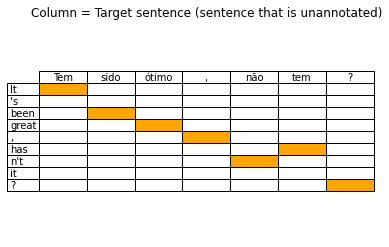

Fraction of One-to-one sentence alignment from en to pt: 0.924%
Total Hamming Loss: 0.189595
Hard Hamming Loss: 0.169398
Soft Hamming Loss: 0.020197
Exact Match Ratio: 0.121457
Percentage of Mismatched Number of Labels in a Sample: 0.729
Skewness: 1.9777182244416285 (Right-skewed)


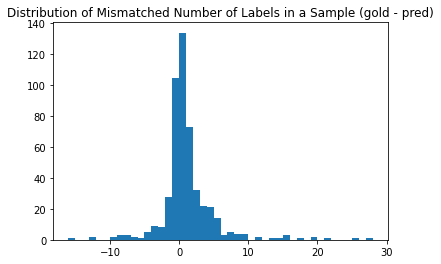

In [ ]:
"""Word-to-word alignment and annotation projection from EN to PT """
src_lang = 'en'
tgt_lang = 'pt'
aligned_result, aligned_sent_to_id = fast_align(src_lang, tgt_lang)
visualize_alignment(aligned_result, 2)
gold, pred, eval_res = transfer_FEs_one2one(aligned_result, aligned_sent_to_id, src_lang, tgt_lang)

Fraction of One-to-one sentence alignment from pt to en: 0.933%
Total Hamming Loss: 0.185792
Hard Hamming Loss: 0.167166
Soft Hamming Loss: 0.018626
Exact Match Ratio: 0.105263
Percentage of Mismatched Number of Labels in a Sample: 0.813
Skewness: 2.1338477674093848 (Right-skewed)


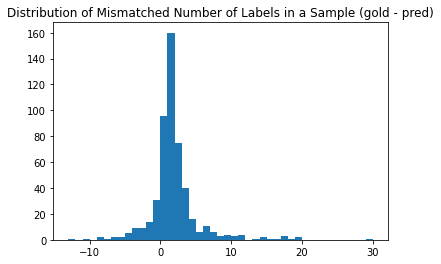

In [ ]:
"""Word-to-word alignment and annotation projection from PT to EN"""
src_lang = 'pt'
tgt_lang = 'en'
aligned_result, aligned_sent_to_id = fast_align(src_lang, tgt_lang)
gold, pred, eval_res = transfer_FEs_one2one(aligned_result, aligned_sent_to_id, src_lang, tgt_lang)

Fraction of One-to-one sentence alignment from de to en: 0.898%
Total Hamming Loss: 0.176369
Hard Hamming Loss: 0.168300
Soft Hamming Loss: 0.008069
Exact Match Ratio: 0.175824
Percentage of Mismatched Number of Labels in a Sample: 0.692
Skewness: 3.2984129471538943 (Right-skewed)


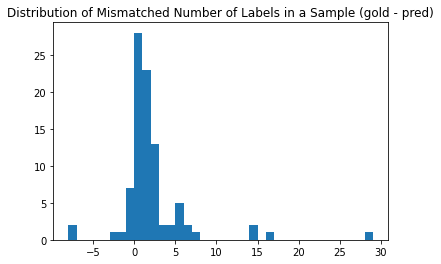

In [ ]:
"""Word-to-word alignment and annotation projection from DE to EN"""
src_lang = 'de'
tgt_lang = 'en'
aligned_result, aligned_sent_to_id = fast_align(src_lang, tgt_lang)
gold, pred, eval_res = transfer_FEs_one2one(aligned_result, aligned_sent_to_id, src_lang, tgt_lang)

Fraction of One-to-one sentence alignment from en to de: 0.968%
Total Hamming Loss: 0.176211
Hard Hamming Loss: 0.162115
Soft Hamming Loss: 0.014097
Exact Match Ratio: 0.196581
Percentage of Mismatched Number of Labels in a Sample: 0.726
Skewness: 1.2868086996570371 (Right-skewed)


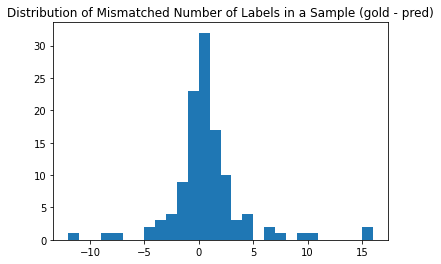

In [ ]:
"""Word-to-word alignment and annotation projection from EN to DE"""
src_lang = 'en'
tgt_lang = 'de'
aligned_result, aligned_sent_to_id = fast_align(src_lang, tgt_lang)
gold, pred, eval_res = transfer_FEs_one2one(aligned_result, aligned_sent_to_id, src_lang, tgt_lang)